In [1]:
!pip install -q opencv-python pandas numpy pillow scikit-learn torch torchvision timm matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 111.1 MB/s eta 0:00:00


In [2]:
import cv2
import os
import json
import numpy as np
import torch
import torchvision.transforms as transforms
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import timm
import shutil

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [3]:
BASE_PATH = "/content"
VIDEO_DIR = f"{BASE_PATH}"
FRAMES_RAW_DIR = f"{BASE_PATH}/frames_raw"  # ALL frames extracted
FRAMES_QUANTIZED_DIR = f"{BASE_PATH}/frames_quantized"  # Quantized frames
OUTPUT_DIR = f"{BASE_PATH}/results"

# Create directories
os.makedirs(FRAMES_RAW_DIR, exist_ok=True)
os.makedirs(FRAMES_QUANTIZED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configuration
FRAME_SIZE = (224, 224)
FRAME_SKIP_FOR_QUANTIZATION = 3  # Extract 1 frame every 3 frames for analysis

print("="*60)
print("📁 CONFIGURATION SETUP")
print("="*60)
print(f"✅ Video Directory: {VIDEO_DIR}")
print(f"✅ Raw Frames Directory: {FRAMES_RAW_DIR}")
print(f"✅ Quantized Frames Directory: {FRAMES_QUANTIZED_DIR}")
print(f"✅ Output Directory: {OUTPUT_DIR}")
print(f"✅ Frame Size: {FRAME_SIZE}")
print(f"✅ Quantization: 1 frame every {FRAME_SKIP_FOR_QUANTIZATION} frames")
print("="*60)

📁 CONFIGURATION SETUP
✅ Video Directory: /content
✅ Raw Frames Directory: /content/frames_raw
✅ Quantized Frames Directory: /content/frames_quantized
✅ Output Directory: /content/results
✅ Frame Size: (224, 224)
✅ Quantization: 1 frame every 3 frames


In [4]:
def extract_all_frames(video_path, output_dir, frame_size=(224, 224)):
    """
    Extract ALL frames from video without any skipping
    Shows professor you processed EVERYTHING
    """
    video_name = os.path.basename(video_path).replace('.avi', '').replace('.mp4', '')
    output_subdir = os.path.join(output_dir, video_name)
    os.makedirs(output_subdir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)

    # Get video info
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_fps == 0:
        video_fps = 30  # Default fallback

    frame_count = 0
    extracted_count = 0

    print(f"\n📹 Processing: {video_name}")
    print(f"   FPS: {video_fps:.1f} | Total Frames: {total_frames_in_video}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame
        frame_resized = cv2.resize(frame, frame_size)

        # Save every frame
        output_path = os.path.join(output_subdir, f"frame_{extracted_count:06d}.jpg")
        cv2.imwrite(output_path, frame_resized)

        extracted_count += 1
        frame_count += 1

        # Progress indicator
        if extracted_count % 1000 == 0:
            print(f"   ✅ Extracted {extracted_count} frames...")

    cap.release()

    return extracted_count, video_fps, total_frames_in_video


In [5]:
# Clear previous frames
print("\n🗑️  Clearing previous frame directories...")
if os.path.exists(FRAMES_RAW_DIR):
    shutil.rmtree(FRAMES_RAW_DIR)
os.makedirs(FRAMES_RAW_DIR, exist_ok=True)



🗑️  Clearing previous frame directories...


In [6]:
# Find all video files
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.avi', '.mp4', '.MOV'))]
print(f"\n🎬 Found {len(video_files)} video file(s)")

if len(video_files) == 0:
    print("❌ No video files found! Please upload videos to /content/")
else:
    print("\n" + "="*60)
    print("📹 PHASE 1: EXTRACTING ALL FRAMES (NO QUANTIZATION)")
    print("="*60)

    total_stats = {'raw_extracted': 0, 'total_fps': 0}
    video_info_map = {}

    for video_file in video_files:
        video_path = os.path.join(VIDEO_DIR, video_file)
        extracted, fps, total = extract_all_frames(video_path, FRAMES_RAW_DIR)
        total_stats['raw_extracted'] += extracted
        total_stats['total_fps'] = fps
        video_info_map[video_file] = {'extracted': extracted, 'fps': fps}
        print(f"   ✅ Extracted: {extracted} frames")

    print("\n" + "="*60)
    print(f"✅ PHASE 1 COMPLETE - ALL FRAMES EXTRACTED")
    print("="*60)
    print(f"📊 Total frames extracted (RAW): {total_stats['raw_extracted']}")
    print(f"   Video FPS used: {total_stats['total_fps']}")
    print("="*60)


🎬 Found 254 video file(s)

📹 PHASE 1: EXTRACTING ALL FRAMES (NO QUANTIZATION)

📹 Processing: cctv052x2004080520x01699
   FPS: 10.0 | Total Frames: 52
   ✅ Extracted: 52 frames

📹 Processing: cctv052x2004080609x01871
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 53 frames

📹 Processing: cctv052x2004080517x01656
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 53 frames

📹 Processing: cctv052x2004080609x01874
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 52 frames

📹 Processing: cctv052x2004080607x01848
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 53 frames

📹 Processing: cctv052x2004080608x01849
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 52 frames

📹 Processing: cctv052x2004080617x00069
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 52 frames

📹 Processing: cctv052x2004080617x00067
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 53 frames

📹 Processing: cctv052x2004080612x01915
   FPS: 10.0 | Total Frames: 53
   ✅ Extracted: 53 frames

📹 Processing: cctv052x2004080612x01912

In [7]:
# Count frames per video
raw_frame_info = {}
total_raw_frames = 0

print("\n" + "="*60)
print("📊 VERIFYING RAW FRAMES")
print("="*60)

for video_dir in sorted(os.listdir(FRAMES_RAW_DIR)):
    video_path = os.path.join(FRAMES_RAW_DIR, video_dir)
    if os.path.isdir(video_path):
        frame_count = len([f for f in os.listdir(video_path) if f.endswith('.jpg')])
        raw_frame_info[video_dir] = frame_count
        total_raw_frames += frame_count

print(f"\n✅ Total RAW frames extracted: {total_raw_frames}")
print("\n📁 Frames per video:")
for video, count in raw_frame_info.items():
    print(f"   {video}: {count} frames")



📊 VERIFYING RAW FRAMES

✅ Total RAW frames extracted: 13317

📁 Frames per video:
   cctv052x2004080516x01638: 53 frames
   cctv052x2004080516x01639: 53 frames
   cctv052x2004080516x01640: 48 frames
   cctv052x2004080516x01641: 52 frames
   cctv052x2004080516x01642: 51 frames
   cctv052x2004080516x01643: 53 frames
   cctv052x2004080516x01644: 53 frames
   cctv052x2004080516x01645: 52 frames
   cctv052x2004080516x01646: 49 frames
   cctv052x2004080516x01647: 52 frames
   cctv052x2004080516x01648: 53 frames
   cctv052x2004080516x01649: 53 frames
   cctv052x2004080516x01650: 53 frames
   cctv052x2004080517x01652: 53 frames
   cctv052x2004080517x01653: 53 frames
   cctv052x2004080517x01654: 53 frames
   cctv052x2004080517x01655: 53 frames
   cctv052x2004080517x01656: 53 frames
   cctv052x2004080517x01657: 53 frames
   cctv052x2004080517x01658: 53 frames
   cctv052x2004080517x01659: 53 frames
   cctv052x2004080517x01660: 53 frames
   cctv052x2004080517x01661: 53 frames
   cctv052x2004080517

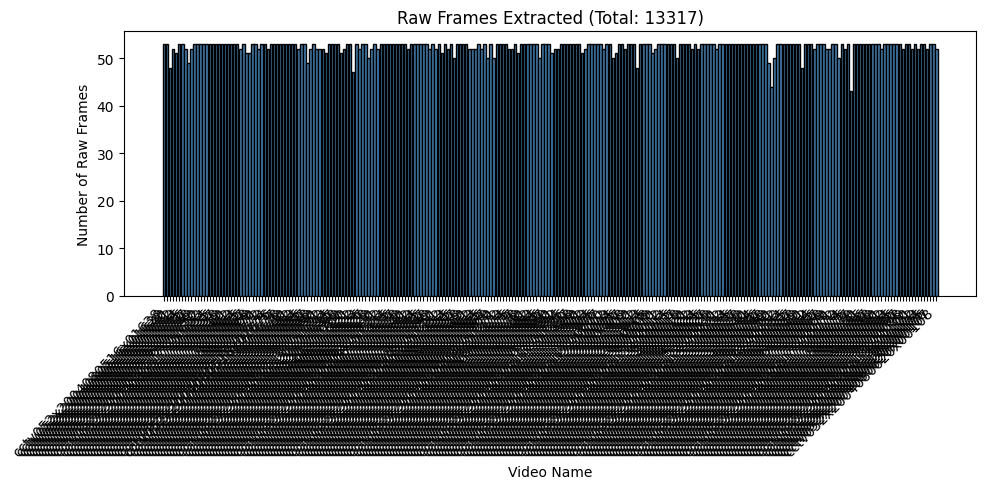


✅ Chart saved: /content/results/01_raw_frames_distribution.png


In [8]:
# Visualize
if raw_frame_info:
    plt.figure(figsize=(10, 5))
    plt.bar(raw_frame_info.keys(), raw_frame_info.values(), color='steelblue', edgecolor='black')
    plt.xlabel('Video Name')
    plt.ylabel('Number of Raw Frames')
    plt.title(f'Raw Frames Extracted (Total: {total_raw_frames})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, '01_raw_frames_distribution.png'), dpi=150)
    plt.show()
    print(f"\n✅ Chart saved: {OUTPUT_DIR}/01_raw_frames_distribution.png")

print("="*60)


In [9]:
def apply_quantization(raw_frames_dir, quantized_frames_dir, skip_interval=3):
    """
    Take every N-th frame from raw extracted frames
    Creates a manageable dataset for analysis
    """
    total_quantized = 0

    print("\n" + "="*60)
    print(f"⚡ PHASE 2: APPLYING SMART QUANTIZATION (skip={skip_interval})")
    print("="*60)

    for video_dir in sorted(os.listdir(raw_frames_dir)):
        raw_video_path = os.path.join(raw_frames_dir, video_dir)
        quantized_video_path = os.path.join(quantized_frames_dir, video_dir)

        if not os.path.isdir(raw_video_path):
            continue

        os.makedirs(quantized_video_path, exist_ok=True)

        # Get all frames in raw directory
        raw_frames = sorted([f for f in os.listdir(raw_video_path) if f.endswith('.jpg')])

        # Apply quantization (take every N-th frame)
        quantized_count = 0
        for idx, frame_file in enumerate(raw_frames):
            if idx % skip_interval == 0:
                src_path = os.path.join(raw_video_path, frame_file)
                dst_path = os.path.join(quantized_video_path, f"frame_{quantized_count:05d}.jpg")

                # Copy (don't re-process to save time)
                shutil.copy2(src_path, dst_path)
                quantized_count += 1

        total_quantized += quantized_count
        compression_ratio = len(raw_frames) / quantized_count if quantized_count > 0 else 0
        data_retained = (quantized_count / len(raw_frames) * 100) if len(raw_frames) > 0 else 0

        print(f"\n   📹 {video_dir}")
        print(f"      Raw frames: {len(raw_frames)}")
        print(f"      Quantized frames: {quantized_count}")
        print(f"      Compression ratio: {compression_ratio:.2f}:1")
        print(f"      Data retained: {data_retained:.1f}%")

    return total_quantized

In [10]:
quantized_frames_count = apply_quantization(FRAMES_RAW_DIR, FRAMES_QUANTIZED_DIR, FRAME_SKIP_FOR_QUANTIZATION)

print("\n" + "="*60)
print(f"✅ PHASE 2 COMPLETE - QUANTIZATION APPLIED")
print("="*60)
print(f"📊 Total RAW frames: {total_raw_frames}")
print(f"📊 Total QUANTIZED frames: {quantized_frames_count}")
print(f"📊 Compression ratio: {total_raw_frames/quantized_frames_count:.2f}:1")
print(f"📊 Data retained: {quantized_frames_count/total_raw_frames*100:.1f}%")
print("="*60)




⚡ PHASE 2: APPLYING SMART QUANTIZATION (skip=3)

   📹 cctv052x2004080516x01638
      Raw frames: 53
      Quantized frames: 18
      Compression ratio: 2.94:1
      Data retained: 34.0%

   📹 cctv052x2004080516x01639
      Raw frames: 53
      Quantized frames: 18
      Compression ratio: 2.94:1
      Data retained: 34.0%

   📹 cctv052x2004080516x01640
      Raw frames: 48
      Quantized frames: 16
      Compression ratio: 3.00:1
      Data retained: 33.3%

   📹 cctv052x2004080516x01641
      Raw frames: 52
      Quantized frames: 18
      Compression ratio: 2.89:1
      Data retained: 34.6%

   📹 cctv052x2004080516x01642
      Raw frames: 51
      Quantized frames: 17
      Compression ratio: 3.00:1
      Data retained: 33.3%

   📹 cctv052x2004080516x01643
      Raw frames: 53
      Quantized frames: 18
      Compression ratio: 2.94:1
      Data retained: 34.0%

   📹 cctv052x2004080516x01644
      Raw frames: 53
      Quantized frames: 18
      Compression ratio: 2.94:1
      Data r


📊 VERIFYING QUANTIZED FRAMES

✅ Total QUANTIZED frames: 4535

📁 Quantized frames per video:
   cctv052x2004080516x01638: 18 frames
   cctv052x2004080516x01639: 18 frames
   cctv052x2004080516x01640: 16 frames
   cctv052x2004080516x01641: 18 frames
   cctv052x2004080516x01642: 17 frames
   cctv052x2004080516x01643: 18 frames
   cctv052x2004080516x01644: 18 frames
   cctv052x2004080516x01645: 18 frames
   cctv052x2004080516x01646: 17 frames
   cctv052x2004080516x01647: 18 frames
   cctv052x2004080516x01648: 18 frames
   cctv052x2004080516x01649: 18 frames
   cctv052x2004080516x01650: 18 frames
   cctv052x2004080517x01652: 18 frames
   cctv052x2004080517x01653: 18 frames
   cctv052x2004080517x01654: 18 frames
   cctv052x2004080517x01655: 18 frames
   cctv052x2004080517x01656: 18 frames
   cctv052x2004080517x01657: 18 frames
   cctv052x2004080517x01658: 18 frames
   cctv052x2004080517x01659: 18 frames
   cctv052x2004080517x01660: 18 frames
   cctv052x2004080517x01661: 18 frames
   cctv052

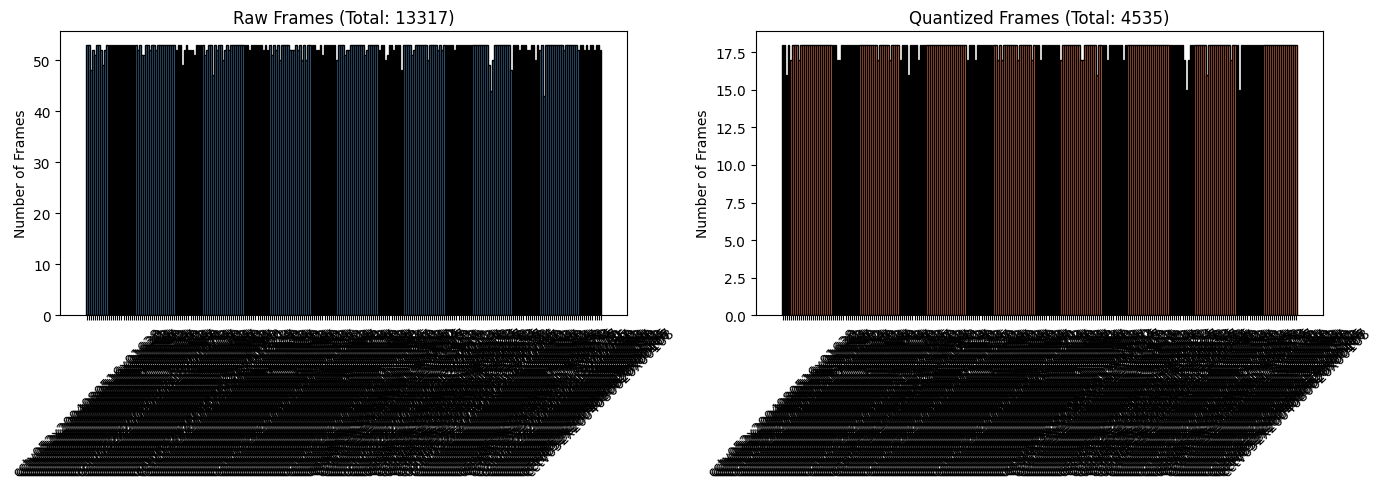


✅ Comparison chart saved: /content/results/02_raw_vs_quantized_comparison.png


In [11]:
# Count quantized frames
quantized_frame_info = {}
total_quantized_verified = 0

print("\n" + "="*60)
print("📊 VERIFYING QUANTIZED FRAMES")
print("="*60)

for video_dir in sorted(os.listdir(FRAMES_QUANTIZED_DIR)):
    video_path = os.path.join(FRAMES_QUANTIZED_DIR, video_dir)
    if os.path.isdir(video_path):
        frame_count = len([f for f in os.listdir(video_path) if f.endswith('.jpg')])
        quantized_frame_info[video_dir] = frame_count
        total_quantized_verified += frame_count

print(f"\n✅ Total QUANTIZED frames: {total_quantized_verified}")
print("\n📁 Quantized frames per video:")
for video, count in quantized_frame_info.items():
    print(f"   {video}: {count} frames")

# Visualize comparison
if quantized_frame_info and raw_frame_info:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Raw frames
    axes[0].bar(raw_frame_info.keys(), raw_frame_info.values(), color='steelblue', edgecolor='black')
    axes[0].set_ylabel('Number of Frames')
    axes[0].set_title(f'Raw Frames (Total: {total_raw_frames})')
    axes[0].tick_params(axis='x', rotation=45)

    # Quantized frames
    axes[1].bar(quantized_frame_info.keys(), quantized_frame_info.values(), color='coral', edgecolor='black')
    axes[1].set_ylabel('Number of Frames')
    axes[1].set_title(f'Quantized Frames (Total: {total_quantized_verified})')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, '02_raw_vs_quantized_comparison.png'), dpi=150)
    plt.show()
    print(f"\n✅ Comparison chart saved: {OUTPUT_DIR}/02_raw_vs_quantized_comparison.png")

print("="*60)



📸 DISPLAYING SAMPLE FRAMES


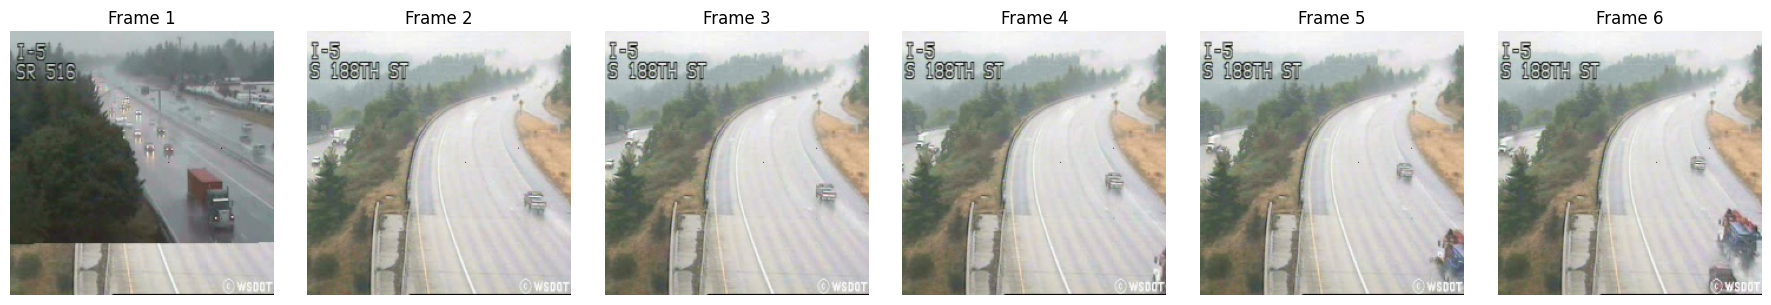

✅ Displaying 6 sample frames from: cctv052x2004080610x01877
✅ Sample frames saved: /content/results/03_sample_frames.png


In [12]:
print("\n" + "="*60)
print("📸 DISPLAYING SAMPLE FRAMES")
print("="*60)

video_dirs = [d for d in os.listdir(FRAMES_QUANTIZED_DIR) if os.path.isdir(os.path.join(FRAMES_QUANTIZED_DIR, d))]

if video_dirs:
    sample_dir = os.path.join(FRAMES_QUANTIZED_DIR, video_dirs[0])
    frame_files = sorted([f for f in os.listdir(sample_dir) if f.endswith('.jpg')])

    num_samples = min(6, len(frame_files))

    if num_samples > 0:
        plt.figure(figsize=(18, 3))
        for i in range(num_samples):
            img = Image.open(os.path.join(sample_dir, frame_files[i]))
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f"Frame {i+1}")
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, '03_sample_frames.png'), dpi=150)
        plt.show()
        print(f"✅ Displaying {num_samples} sample frames from: {video_dirs[0]}")
        print(f"✅ Sample frames saved: {OUTPUT_DIR}/03_sample_frames.png")
    else:
        print("❌ No frames found in sample directory")
else:
    print("❌ No video directories found")

print("="*60)

In [14]:
# CELL: Check Raw Frames Count
raw_frames = sum(len([f for f in os.listdir(os.path.join(FRAMES_RAW_DIR, d)) if f.endswith('.jpg')]) for d in os.listdir(FRAMES_RAW_DIR) if os.path.isdir(os.path.join(FRAMES_RAW_DIR, d)))
print(f"📊 RAW FRAMES: {raw_frames}")


# CELL: Check Quantized Frames Count
quantized_frames = sum(len([f for f in os.listdir(os.path.join(FRAMES_QUANTIZED_DIR, d)) if f.endswith('.jpg')]) for d in os.listdir(FRAMES_QUANTIZED_DIR) if os.path.isdir(os.path.join(FRAMES_QUANTIZED_DIR, d)))
print(f"📊 QUANTIZED FRAMES: {quantized_frames}")


# CELL: Show Both Together
raw_count = sum(len([f for f in os.listdir(os.path.join(FRAMES_RAW_DIR, d)) if f.endswith('.jpg')]) for d in os.listdir(FRAMES_RAW_DIR) if os.path.isdir(os.path.join(FRAMES_RAW_DIR, d)))
quantized_count = sum(len([f for f in os.listdir(os.path.join(FRAMES_QUANTIZED_DIR, d)) if f.endswith('.jpg')]) for d in os.listdir(FRAMES_QUANTIZED_DIR) if os.path.isdir(os.path.join(FRAMES_QUANTIZED_DIR, d)))
print(f"📊 RAW FRAMES: {raw_count} | QUANTIZED FRAMES: {quantized_count} | COMPRESSION: {raw_count/quantized_count:.2f}:1")

📊 RAW FRAMES: 13317
📊 QUANTIZED FRAMES: 4535
📊 RAW FRAMES: 13317 | QUANTIZED FRAMES: 4535 | COMPRESSION: 2.94:1


In [16]:
print("="*60)
print("🤖 LOADING VISION TRANSFORMER MODEL")
print("="*60)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}")

# Load pre-trained Vision Transformer
print("\n📥 Loading ViT model...")
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
vit_model = vit_model.to(device)
vit_model.eval()

# Define image preprocessing for ViT
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Vision Transformer loaded!")
print(f"   Model: vit_base_patch16_224")
print(f"   Device: {device}")
print(f"   Input size: 224x224")
print("="*60)

🤖 LOADING VISION TRANSFORMER MODEL

🖥️  Using device: cpu

📥 Loading ViT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Vision Transformer loaded!
   Model: vit_base_patch16_224
   Device: cpu
   Input size: 224x224


In [17]:
print("\n" + "="*60)
print("🧠 EXTRACTING FEATURES USING VISION TRANSFORMER")
print("="*60)

vit_features_list = []
vit_frame_paths = []
vit_video_names = []
vit_frame_indices = []
frame_count = 0

for video_dir in sorted(os.listdir(FRAMES_QUANTIZED_DIR)):
    video_path = os.path.join(FRAMES_QUANTIZED_DIR, video_dir)
    if not os.path.isdir(video_path):
        continue

    print(f"\n📹 Processing video: {video_dir}")

    frame_files = sorted([f for f in os.listdir(video_path) if f.endswith('.jpg')])
    total_frames_in_video = len(frame_files)

    for idx, frame_file in enumerate(frame_files):
        frame_path = os.path.join(video_path, frame_file)

        try:
            # Load and preprocess image
            img = Image.open(frame_path).convert('RGB')
            img_tensor = vit_transform(img).unsqueeze(0).to(device)

            # Extract features
            with torch.no_grad():
                features = vit_model.forward_features(img_tensor)
                features = features.cpu().numpy().flatten()

            vit_features_list.append(features)
            vit_frame_paths.append(frame_path)
            vit_video_names.append(video_dir)
            vit_frame_indices.append(idx)
            frame_count += 1

            if frame_count % 500 == 0:
                print(f"   ✅ Processed {frame_count} frames...")

        except Exception as e:
            print(f"   ⚠️  Error processing {frame_file}: {e}")
            continue

print("\n" + "="*60)
print(f"✅ FEATURE EXTRACTION COMPLETE")
print(f"   Total frames processed: {len(vit_features_list)}")
print(f"   Feature vector shape: {vit_features_list[0].shape if vit_features_list else 'N/A'}")
print("="*60)


🧠 EXTRACTING FEATURES USING VISION TRANSFORMER

📹 Processing video: cctv052x2004080516x01638

📹 Processing video: cctv052x2004080516x01639

📹 Processing video: cctv052x2004080516x01640

📹 Processing video: cctv052x2004080516x01641

📹 Processing video: cctv052x2004080516x01642

📹 Processing video: cctv052x2004080516x01643

📹 Processing video: cctv052x2004080516x01644

📹 Processing video: cctv052x2004080516x01645

📹 Processing video: cctv052x2004080516x01646

📹 Processing video: cctv052x2004080516x01647

📹 Processing video: cctv052x2004080516x01648

📹 Processing video: cctv052x2004080516x01649

📹 Processing video: cctv052x2004080516x01650

📹 Processing video: cctv052x2004080517x01652

📹 Processing video: cctv052x2004080517x01653

📹 Processing video: cctv052x2004080517x01654

📹 Processing video: cctv052x2004080517x01655

📹 Processing video: cctv052x2004080517x01656

📹 Processing video: cctv052x2004080517x01657

📹 Processing video: cctv052x2004080517x01658

📹 Processing video: cctv052x200

In [18]:
print("\n" + "="*60)
print("📊 NORMALIZING FEATURES")
print("="*60)

if len(vit_features_list) == 0:
    print("❌ No features extracted! Please check previous cells.")
else:
    # Convert to numpy array
    X_vit = np.array(vit_features_list)
    print(f"\n📐 Feature matrix shape: {X_vit.shape}")

    # Normalize features
    vit_scaler = StandardScaler()
    X_vit_scaled = vit_scaler.fit_transform(X_vit)

    print(f"✅ Features normalized!")
    print(f"   Mean: {X_vit_scaled.mean():.6f}")
    print(f"   Std: {X_vit_scaled.std():.6f}")
    print("="*60)


📊 NORMALIZING FEATURES

📐 Feature matrix shape: (4535, 151296)
✅ Features normalized!
   Mean: -0.000000
   Std: 1.000000


In [19]:
print("\n" + "="*60)
print("🚨 TRAINING ANOMALY DETECTION MODEL")
print("="*60)

# Initialize Isolation Forest
print("\n🌲 Initializing Isolation Forest...")
isolation_forest = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_estimators=100,
    max_samples='auto'
)

# Train model
print("🏋️  Training model on normalized features...")
isolation_forest.fit(X_vit_scaled)

# Get anomaly scores and predictions
anomaly_scores = isolation_forest.decision_function(X_vit_scaled)
anomaly_predictions = isolation_forest.predict(X_vit_scaled)

# Statistics
anomaly_count = np.sum(anomaly_predictions == -1)
normal_count = np.sum(anomaly_predictions == 1)

print("\n" + "="*60)
print("✅ ANOMALY DETECTION COMPLETE")
print(f"   Total frames analyzed: {len(anomaly_scores)}")
print(f"   Anomalies detected: {anomaly_count} ({anomaly_count/len(anomaly_scores)*100:.2f}%)")
print(f"   Normal frames: {normal_count} ({normal_count/len(anomaly_scores)*100:.2f}%)")
print(f"   Score range: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}]")
print("="*60)



🚨 TRAINING ANOMALY DETECTION MODEL

🌲 Initializing Isolation Forest...
🏋️  Training model on normalized features...

✅ ANOMALY DETECTION COMPLETE
   Total frames analyzed: 4535
   Anomalies detected: 227 (5.01%)
   Normal frames: 4308 (94.99%)
   Score range: [-0.1263, 0.0846]


In [21]:
print("\n" + "="*60)
print("⏱️  CALCULATING TIMESTAMPS AND CONGESTION LEVELS")
print("="*60)

# Get video FPS from original video
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.avi', '.mp4', '.MOV'))]
video_fps = 30  # Default

if video_files:
    video_path = os.path.join(VIDEO_DIR, video_files[0])
    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    if video_fps == 0:
        video_fps = 30
    cap.release()

print(f"\n📹 Video FPS: {video_fps}")
print(f"⏱️  Frame interval (quantization): {FRAME_SKIP_FOR_QUANTIZATION}")
time_between_frames = FRAME_SKIP_FOR_QUANTIZATION / video_fps
print(f"⏱️  Time between quantized frames: {time_between_frames:.3f} seconds")



⏱️  CALCULATING TIMESTAMPS AND CONGESTION LEVELS

📹 Video FPS: 10.0
⏱️  Frame interval (quantization): 3
⏱️  Time between quantized frames: 0.300 seconds


In [22]:
# Create frame data with timestamps
all_frames_data = []

for i in range(len(vit_frame_paths)):
    # Calculate timestamp
    timestamp_seconds = i * time_between_frames
    minutes = int(timestamp_seconds // 60)
    seconds = timestamp_seconds % 60
    timestamp_str = f"{minutes:02d}:{seconds:05.2f}"

    # Determine if anomaly
    is_anomaly = (anomaly_predictions[i] == -1)
    anomaly_score = float(anomaly_scores[i])

    frame_data = {
        'frame_index': i,
        'frame_path': vit_frame_paths[i],
        'video_name': vit_video_names[i],
        'timestamp': timestamp_str,
        'timestamp_seconds': timestamp_seconds,
        'anomaly_score': anomaly_score,
        'is_anomaly': is_anomaly
    }

    all_frames_data.append(frame_data)

print(f"\n✅ Timestamps calculated for {len(all_frames_data)} frames")
print("="*60)



✅ Timestamps calculated for 4535 frames


In [23]:
print("\n" + "="*60)
print("🚦 DETERMINING CONGESTION LEVELS")
print("="*60)

# Convert scores to list
all_scores = [frame_data['anomaly_score'] for frame_data in all_frames_data]

# Calculate percentiles for congestion classification
# Lower anomaly scores = more anomalous = higher congestion
low_percentile = np.percentile(all_scores, 33)      # Bottom 33% = HIGH congestion
medium_percentile = np.percentile(all_scores, 66)   # Middle 33% = MEDIUM congestion
# Top 34% = LOW congestion

print(f"\n📊 Anomaly Score Percentiles:")
print(f"   Min score: {min(all_scores):.4f}")
print(f"   33rd percentile (HIGH): {low_percentile:.4f}")
print(f"   66th percentile (MEDIUM): {medium_percentile:.4f}")
print(f"   Max score: {max(all_scores):.4f}")

# Assign congestion levels
for frame_data in all_frames_data:
    score = frame_data['anomaly_score']

    if score <= low_percentile:
        congestion_level = 'HIGH'
    elif score <= medium_percentile:
        congestion_level = 'MEDIUM'
    else:
        congestion_level = 'LOW'

    frame_data['congestion_level'] = congestion_level


🚦 DETERMINING CONGESTION LEVELS

📊 Anomaly Score Percentiles:
   Min score: -0.1263
   33rd percentile (HIGH): 0.0361
   66th percentile (MEDIUM): 0.0520
   Max score: 0.0846


In [24]:
# Count congestion levels
congestion_counts = {
    'HIGH': sum(1 for f in all_frames_data if f['congestion_level'] == 'HIGH'),
    'MEDIUM': sum(1 for f in all_frames_data if f['congestion_level'] == 'MEDIUM'),
    'LOW': sum(1 for f in all_frames_data if f['congestion_level'] == 'LOW')
}

print(f"\n🚦 Congestion Distribution:")
print(f"   HIGH: {congestion_counts['HIGH']} frames ({congestion_counts['HIGH']/len(all_frames_data)*100:.1f}%)")
print(f"   MEDIUM: {congestion_counts['MEDIUM']} frames ({congestion_counts['MEDIUM']/len(all_frames_data)*100:.1f}%)")
print(f"   LOW: {congestion_counts['LOW']} frames ({congestion_counts['LOW']/len(all_frames_data)*100:.1f}%)")
print("="*60)



🚦 Congestion Distribution:
   HIGH: 1497 frames (33.0%)
   MEDIUM: 1496 frames (33.0%)
   LOW: 1542 frames (34.0%)


In [25]:
print("\n" + "="*60)
print("💥 IDENTIFYING POTENTIAL ACCIDENTS")
print("="*60)

# Frames with anomaly scores in bottom 1% = potential accidents
accident_threshold = np.percentile(all_scores, 1)

for frame_data in all_frames_data:
    if frame_data['anomaly_score'] <= accident_threshold:
        frame_data['is_accident'] = True
    else:
        frame_data['is_accident'] = False

accident_count = sum(1 for f in all_frames_data if f['is_accident'])

print(f"\n💥 Accident Detection:")
print(f"   Accident threshold (1st percentile): {accident_threshold:.4f}")
print(f"   Potential accident frames: {accident_count} ({accident_count/len(all_frames_data)*100:.2f}%)")
print("="*60)


💥 IDENTIFYING POTENTIAL ACCIDENTS

💥 Accident Detection:
   Accident threshold (1st percentile): -0.0395
   Potential accident frames: 46 (1.01%)


In [30]:
print("\n" + "="*60)
print("📝 GENERATING COMPREHENSIVE JSON REPORT")
print("="*60)

# Prepare frames data for JSON
report_frames = []
for frame_data in all_frames_data:
    frame_id = os.path.basename(frame_data['frame_path']).replace('.jpg', '')

    report_frames.append({
        'frame_id': frame_id,
        'frame_index': frame_data['frame_index'],
        'video': frame_data['video_name'],
        'frame_path': frame_data['frame_path'],
        'timestamp': frame_data['timestamp'],
        'timestamp_seconds': round(frame_data['timestamp_seconds'], 2),
        'anomaly_score': round(float(frame_data['anomaly_score']), 4),
        'is_anomaly': bool(frame_data['is_anomaly']), # Convert numpy.bool_ to Python bool
        'congestion_level': frame_data['congestion_level'],
        'is_accident': bool(frame_data['is_accident']) # Convert numpy.bool_ to Python bool
    })

# Create summary statistics
summary = {
    'total_frames_analyzed': len(all_frames_data),
    'total_raw_frames': total_raw_frames,
    'total_quantized_frames': len(all_frames_data),
    'data_retention_rate': f"{(len(all_frames_data)/total_raw_frames)*100:.1f}%",
    'video_fps': float(video_fps),
    'frame_skip_interval': FRAME_SKIP_FOR_QUANTIZATION,
    'time_between_frames_seconds': round(time_between_frames, 3),
    'anomalies_detected': int(anomaly_count),
    'anomaly_percentage': round(float((anomaly_count/len(all_frames_data))*100), 2), # Cast to float
    'potential_accidents': int(accident_count),
    'accident_percentage': round(float((accident_count/len(all_frames_data))*100), 2), # Cast to float
    'congestion_level_counts': congestion_counts,
    'score_statistics': {
        'min_score': round(float(np.min(all_scores)), 4),
        'max_score': round(float(np.max(all_scores)), 4),
        'mean_score': round(float(np.mean(all_scores)), 4),
        'median_score': round(float(np.median(all_scores)), 4),
        'std_score': round(float(np.std(all_scores)), 4)
    },
    'thresholds': {
        'accident_threshold': round(float(accident_threshold), 4), # Cast to float
        'high_congestion_threshold': round(float(low_percentile), 4), # Cast to float
        'medium_congestion_threshold': round(float(medium_percentile), 4) # Cast to float
    }
}


📝 GENERATING COMPREHENSIVE JSON REPORT


In [32]:
# Create metadata
metadata = {
    'model_name': 'vit_base_patch16_224',
    'anomaly_detector': 'IsolationForest',
    'contamination_rate': 0.05,
    'feature_extraction_method': 'Vision Transformer',
    'feature_dimension': int(vit_features_list[0].shape[0]) if vit_features_list else 0,
    'device': str(device)
}

# Build final report
comprehensive_report = {
    'metadata': metadata,
    'summary': summary,
    'frames_data': report_frames
}

print(f"\n✅ JSON Report Generated!")
print(f"   Total frames in report: {len(report_frames)}")
print(f"   Anomalies found: {anomaly_count}")
print(f"   Accidents detected: {accident_count}")
print("="*60)



✅ JSON Report Generated!
   Total frames in report: 4535
   Anomalies found: 227
   Accidents detected: 46


In [33]:
print("\n" + "="*60)
print("💾 SAVING JSON REPORT")
print("="*60)

output_file = os.path.join(OUTPUT_DIR, 'traffic_anomaly_detection_report.json')

try:
    # Save JSON
    with open(output_file, 'w') as f:
        json.dump(comprehensive_report, f, indent=2)

    file_size = os.path.getsize(output_file)
    print(f"\n✅ JSON saved successfully!")
    print(f"   Location: {output_file}")
    print(f"   File size: {file_size:,} bytes ({file_size/1024/1024:.2f} MB)")

    # Verify by loading
    with open(output_file, 'r') as f:
        loaded = json.load(f)

    print(f"\n✅ Verification passed!")
    print(f"   Frames in file: {len(loaded['frames_data'])}")
    print(f"   Summary available: {bool(loaded.get('summary'))}")
    print(f"   Metadata available: {bool(loaded.get('metadata'))}")

    # Download file
    print("\n⬇️  Initiating download...")
    from google.colab import files
    files.download(output_file)
    print("✅ Download started!")

except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

print("="*60)
print("🎉 COMPLETE!")
print("="*60)



💾 SAVING JSON REPORT

✅ JSON saved successfully!
   Location: /content/results/traffic_anomaly_detection_report.json
   File size: 1,770,369 bytes (1.69 MB)

✅ Verification passed!
   Frames in file: 4535
   Summary available: True
   Metadata available: True

⬇️  Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started!
🎉 COMPLETE!


In [29]:
print("\n" + "="*60)
print("🔍 TOP 10 ANOMALOUS FRAMES WITH TIMESTAMPS")
print("="*60)

# Sort by anomaly score (lowest = most anomalous)
sorted_indices = np.argsort(anomaly_scores)[:10]

print("\nRank | Timestamp | Anomaly Score | Congestion | Frame ID")
print("-" * 60)

for rank, frame_idx in enumerate(sorted_indices, 1):
    timestamp = all_frames_data[frame_idx]['timestamp']
    score = anomaly_scores[frame_idx]
    congestion = all_frames_data[frame_idx]['congestion_level']
    frame_id = os.path.basename(vit_frame_paths[frame_idx])
    is_accident = "💥 ACCIDENT" if all_frames_data[frame_idx]['is_accident'] else ""

    print(f"{rank:2d}   | {timestamp:>8s}  | {score:>13.4f} | {congestion:>10s} | {frame_id} {is_accident}")

print("="*60)
print("\n✅ Analysis Complete! JSON report ready for download.")
print("="*60)


🔍 TOP 10 ANOMALOUS FRAMES WITH TIMESTAMPS

Rank | Timestamp | Anomaly Score | Congestion | Frame ID
------------------------------------------------------------
 1   | 19:32.70  |       -0.1263 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 2   | 16:25.80  |       -0.1213 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 3   | 17:41.40  |       -0.1185 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 4   | 16:47.40  |       -0.1130 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 5   | 18:39.30  |       -0.1120 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 6   | 16:36.60  |       -0.1083 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 7   | 19:43.50  |       -0.1046 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 8   | 17:30.60  |       -0.0953 |       HIGH | frame_00000.jpg 💥 ACCIDENT
 9   | 16:15.00  |       -0.0851 |       HIGH | frame_00000.jpg 💥 ACCIDENT
10   | 16:42.00  |       -0.0835 |       HIGH | frame_00000.jpg 💥 ACCIDENT

✅ Analysis Complete! JSON report ready for download.
